In [1]:
import numpy as np 
import sklearn as skl
import matplotlib.pyplot as plt
import tensorflow as tf 
import scipy 
import pandas as pd
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Tarea 1: Dataset Iris: Por Roberto Cholaky

La parte siguiente del código irá dedicada a la obtención de los datos de entrenamiento y testeo. Se generará un arreglo de numpy que tenga todas las caracaterísticas de cada ejemplo en las filas. De este modo, si el arreglo es de M ejemplos y cada ejemplo tiene N características se tendrá que la matriz generada será de (M,N). Además para guardar los elementos de los labels en otro arregle de tamaño (M,C) donde C es la cantidad clases de clasificación (Esto ya que se utilizará one-hot-encoding), así cada fila en la matriz de características tendrá su label correspondiente.

In [2]:
#acá se define el nombre del archivo que se procede a trabajar:
file_name = 'iris.data'
#generamos listas para guardar los elementos del archivo de datos
labels = list()
data = list()
one_hot_classes = dict()
#Una vez llenas estas listas se procederá a pasar esta a un arreglo de numpy como se explicó en el apartado anterior:
# abrimos el archivo file_name:
with open(file_name) as file: 
    #procedemos a acceder a todas las filas del archivo:
    for line in file: 
        #dividimos el archivo por comas donde sabemos que el último elemento es el label
        splited_line = line.split(',')
        #Pasamos a checkear si el arreglo queda vacio o no:
        if splited_line != ['\n']:
            #Unimos las listas con los nuevos elementos
            # el elemento [-1] indica que se accede al último elemento del arreglo
            labels.append(splited_line[-1])
            data.append(splited_line[:-1])
            
#set de valores (valores sin repetir de la lista)
named_labels = labels
classification_set = set(labels)
n_C = len(classification_set)
for index, value in enumerate(classification_set):
    zero = np.zeros((1, n_C))
    if index == 0:
        zero[:,index] = 1
        one_hot_classes[value]= zero 
    else:
        zero[:,index] = 1
        one_hot_classes[value]= zero

#Procedemos a calcular el one-hot encoding:
for i, example in enumerate(labels):
    labels[i] = one_hot_classes[example]

#vstack es un método de la librería de numpy la que toma dos listas y las apila como filas. De este modo,
# si tenemos N filas de M elementos este nos entrega una función de (N,M).
data = np.vstack(data).astype('float64')
#data = (data-mu_data)/std_data
labels = np.vstack(labels)
permutation = np.random.permutation(data.shape[0])
data = data[permutation,:]
labels = labels[permutation]
named_labels = np.vstack(named_labels)
#print the shape of data and labels:
print('feature data shape '+ str(data.shape))
print('labels of data shape ' + str(labels.shape))

feature data shape (150, 4)
labels of data shape (150, 3)


# Normalización de los datos: 
Es sabido que una manera de obtener un entrenamiento más rápido es mediante el uso de normalización de los datos de entrada, esto se debe a que datos normalizados permite que la región de optimización que se tiene sea más uniforme y por ende el método de descenso de gradiente sea más rápido debido a que los gradientes permiten un avance más directo hacia los mínimos.

In [3]:
mu_data = np.mean(data, axis= 0, keepdims = True)
std_data = np.std(data, axis = 0, keepdims = True)
print('shape de la media ' + str(mu_data.shape))
print('shape de la desviación estandard '+str(std_data.shape))
#data Normalization: 
data = (data-mu_data)/np.square(std_data)

shape de la media (1, 4)
shape de la desviación estandard (1, 4)


In [4]:
data_max = np.max(data, axis=0)
data_min = np.min(data, axis=0)
data = (data-data_min)/(data_max-data_min)

In [5]:
#cross validation_set: generates training and test set with a 80% and 20% respectively from the dataset:
def cross_validation_set(X, Y): 
    M= X.shape[0]
    permutation = np.random.permutation(M)
    X_shuffled = X[permutation]
    Y_shuffled = Y[permutation]
    train_limit = int(M*0.8)
    X_train = X_shuffled[:train_limit]
    Y_train = Y_shuffled[:train_limit]
    X_test = X_shuffled[train_limit:]
    Y_testing = Y_shuffled[train_limit:]
    return X_train, Y_train, X_test, Y_testing

X_train, Y_train, X_test, Y_testing = cross_validation_set(data, labels)
print(X_train.shape)
print(X_test.shape)


(120, 4)
(30, 4)


In [120]:
def tanh(X):
    exp = np.exp(X)
    exp_ = np.exp(-1*X)
    tanh = (exp-exp_)/(exp+exp_)
    return tanh

def softmax(X):
    exp = np.exp(X)
    sum_exp = np.sum(exp, axis=1)
    sum_exp = np.expand_dims(sum_exp, -1)
    return exp/(sum_exp+0.000002)


def dtanh(x):
    return 1 - np.square(tanh(x))




class MLP:
    def __init__(self, X, Y, n_layers, n_hidden_units):
        W = dict()
        b = dict()
        dZ = dict()
        dW = dict()
        db = dict()
        A_cache = dict()
        Z_cache = dict()
        self.n_layers = n_layers
        self.learning_rate = 0.1
        first_shape = X.shape[1]
        second_shape = n_hidden_units
        for layer in range(n_layers):
            W['W'+str(layer+1)] = np.random.rand(first_shape, second_shape)
            b['b'+str(layer+1)] = np.zeros((1,second_shape))
            first_shape = second_shape
        W['W'+str(self.n_layers+1)] = np.random.rand(n_hidden_units, Y.shape[1])
        b['b'+str(self.n_layers+1)] = np.zeros((1, Y.shape[1]))
        self.parameters = dict()
        self.parameters['W'] = W
        self.parameters['b'] = b
        self.parameters['dZ'] = dZ
        self.parameters['dW'] = dW
        self.parameters['db'] = db
        self.parameters['A_cache'] = A_cache
        self.parameters['Z_cache'] = Z_cache
    
    def forwardPass(self, X, parameters):
        W = parameters['W']
        b = parameters['b']
        A_cache = dict()
        Z_cache = dict()
        In = X 
        A_cache['A0']= X
        for layer in range(self.n_layers):
            Z = np.dot(In, W['W'+str(layer+1)])+b['b'+str(layer+1)]
            Z_cache['Z'+str(layer+1)] = Z 
            A = tanh(Z)
            A_cache['A'+str(layer+1)] = A
            In = A
        Z = np.dot(In, W['W'+str(self.n_layers+1)])+b['b'+str(self.n_layers+1)]
        Z_cache['Z'+str(self.n_layers+1)] = Z 
        Y_pred = softmax(Z) 
        
        model_parameters = dict()
        model_parameters['W'] = parameters['W']
        model_parameters['b'] = parameters['b']
        model_parameters['dW'] = parameters['dW']
        model_parameters['db'] = parameters['db']
        model_parameters['dZ'] = parameters['dZ']
        model_parameters['A_cache'] = A_cache
        model_parameters['Z_cache'] = Z_cache
        return Y_pred, model_parameters 
    
    def Loss(self, Y_pred, Y):
        log_Ypred = np.log(Y_pred+0.000002)
        Ylog_Ypred = -Y*log_Ypred
        L_i = np.sum(Ylog_Ypred, axis= 1)
        loss = np.mean(L_i)
        return loss
        
        
    def backPropagation(self, Y_pred, Y, parameters):
        W = parameters['W']  
        A_cache = parameters['A_cache']
        Z_cache = parameters['Z_cache']
        dZ = parameters['dZ']
        dW = parameters['dW'] 
        db = parameters['db']
        #we start by saving the number of examples:
        M = Y.shape[0]
        #Dz is of shape (M, C) where M is the number of examples and C is the number of classes:
        dZ['Z'+str(self.n_layers+1)] = (Y_pred - Y)
        # DW for the last layer is of shape (n_[l-1], C) where n_[l-1] is the output shape of layer l-1 and C is the number 
        #of classes: so we multiply A.T times dZ so we have (n_[l-1], M)X(M, C)= (n_[l-1], C).
        dW['W'+str(self.n_layers+1)] = np.dot(A_cache['A'+str(self.n_layers)].T, dZ['Z'+str(self.n_layers+1)])
        db['b'+str(self.n_layers+1)] = (1/M)*np.sum(dZ['Z'+str(self.n_layers+1)], axis=0, keepdims=True)
        #We loop over all the other layers
        for layer in range(self.n_layers, 0, -1):
            #as dZ[l] is of shape (M, n_[l]) and W[l] is of shape (n_[l-1], n_l[l]) dZ[l]xW.T returns the correct dimension
            #because dZ[l-1] is of shape (M, n[l-1])
            dZ['Z'+str(layer)] = np.dot(dZ['Z'+str(layer+1)], W['W'+str(layer+1)].T)*dtanh(Z_cache['Z'+str(layer)])
            # DW for lth layer (n_[l-1], n_[l]) so we multiply A.T times dZ so we have (n_[l-1], M)X(M, n_[l])= (n_[l-1], C): 
            dW['W'+str(layer)] = (1/M)*np.dot(A_cache['A'+str(layer-1)].T, dZ['Z'+str(layer)])
            db['b'+str(layer)] = (1/M)*np.sum(dZ['Z' + str(layer)], axis=0, keepdims=True)
        parameters['dZ'] = dZ
        parameters['dW'] = dW
        parameters['db'] = db
        parameters = self.update_parameters(parameters)
        return parameters
        
    
    
    def update_parameters(self, parameters):
        W = parameters['W']
        b = parameters['b']
        dW = parameters['dW'] 
        db = parameters['db']
        for layer in range(1, self.n_layers+1, 1):
            W['W'+str(layer+1)] = W['W'+str(layer+1)]-self.learning_rate*dW['W'+str(layer+1)]
            b['b'+str(layer+1)] = b['b'+str(layer+1)]-self.learning_rate*db['b'+str(layer+1)]
        parameters['W'] = W
        parameters['b'] = b
        self.parameters
        return parameters
        
    
    
    def calc_accuracy(self, Y_pred, Y):
        pred = np.expand_dims(np.argmax(Y_pred, axis=-1), -1)
        real = np.expand_dims(np.argmax(Y, axis=-1),-1)
        acc = np.sum((pred==real))/Y.shape[0]
        return acc
    
            
        

    def train(self, X, Y, Epochs, learning_rate):
        parameters = self.parameters
        training_loss = list()
        testing_loss  = list()
        training_accuracy = list()
        testing_accuracy = list()
        self.learning_rate= learning_rate
        X_train, Y_train, X_test, Y_test = cross_validation_set(X, Y)
        for epoch in range(1, Epochs+1):
            Y_pred, parameters = self.forwardPass(X_train, parameters)
            train_loss = self.Loss(Y_pred, Y_train)
            train_acc = self.calc_accuracy(Y_pred, Y_train)
            training_loss.append(train_loss)
            training_accuracy.append(train_acc)
            #now we test the results on the test set:
            test_pred, _ = self.forwardPass(X_test, parameters)
            test_loss = self.Loss(test_pred, Y_test)
            testing_loss.append(test_loss)
            test_acc = self.calc_accuracy(test_pred, Y_test)
            testing_accuracy.append(test_acc)
            if epoch%5==0:
                print('Epoch {N_epoch} is train loss: {loss}, train accuracy: {accuracy}, test loss: {test_loss}, test accuracy: {test_acc}'.format(N_epoch=epoch, loss=train_loss,\
                                                                                                                                            accuracy= train_acc, test_loss=test_loss,\
                                                                                                                                            test_acc = test_acc))
            parameters = self.backPropagation(Y_pred, Y_train, parameters)
        print('Trainig is done:')
        print('the mean training loss is {loss} and the mean training accuracy is {acc}'.format(loss = np.mean(training_loss), acc= np.mean(training_accuracy)))
        print('the mean testing loss is {loss} and the mean testing accuracy is {acc}'.format(loss = np.mean(testing_loss), acc= np.mean(testing_accuracy)))
        fig, ax = plt.subplots()
        train = ax.plot(range(1, Epochs+1), training_loss, '-b', label='training loss')
        test = ax.plot(range(1, Epochs+1), testing_loss, '-r', label= 'testing loss')
        ax.legend()
        ax.set_title('models loss with {epochs} epochs of training'.format(epochs=Epochs))
        ax.set_xlabel('Epochs')
        ax.set_ylabel('loss')
        plt.show()
        fig, ax = plt.subplots()
        train = ax.plot(range(1, Epochs+1), training_accuracy, '-b', label='training accuracy')
        test = ax.plot(range(1, Epochs+1), testing_accuracy, '-r', label= 'testing accuracy')
        plt.legend()
        ax.set_title('models accuracy with {epochs} epochs of training'.format(epochs=Epochs))
        ax.set_xlabel('Epochs')
        ax.set_ylabel('accuracy')
        plt.show()
        plt.show()
            

In [128]:
myMlp = MLP(data, labels, n_layers = 3, n_hidden_units=4)
init_weights = myMlp.parameters['W']
init_bias = myMlp.parameters['b']

In [129]:
X_train, Y_train, X_test, Y_testing = cross_validation_set(data, labels)

In [86]:
Y_pred, parameters = myMlp.forwardPass(X_train, myMlp.parameters)
print(parameters['Z_cache']['Z2'].shape)
for key in parameters['b'].keys():
    print(parameters['b'][key].shape)
Y_pred_test,_  = myMlp.forwardPass(X_test, parameters)
parameters = myMlp.backPropagation(Y_pred, Y_train, parameters)
for key in parameters['b'].keys():
    print(parameters['b'][key].shape)


(120, 3)
(1, 3)
(1, 3)
(1, 3)
b= (1, 3)
(120, 3)
(1, 3)
(120, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)


Epoch 5 is train loss: 8.202729359465591, train accuracy: 0.35, test loss: 9.21203640382519, test accuracy: 0.26666666666666666
Epoch 10 is train loss: 1.6141997483876795, train accuracy: 0.4, test loss: 1.6406199773431298, test accuracy: 0.3333333333333333
Epoch 15 is train loss: 0.9599242274070582, train accuracy: 0.45, test loss: 0.937988643601272, test accuracy: 0.3333333333333333
Epoch 20 is train loss: 0.6740122807768434, train accuracy: 0.7166666666666667, test loss: 0.6630069944147537, test accuracy: 0.7333333333333333
Epoch 25 is train loss: 0.6117335408048855, train accuracy: 0.6833333333333333, test loss: 0.5961409161469275, test accuracy: 0.8
Epoch 30 is train loss: 1.3931721939938504, train accuracy: 0.35, test loss: 1.4950776950259639, test accuracy: 0.26666666666666666
Epoch 35 is train loss: 0.643883413138544, train accuracy: 0.7416666666666667, test loss: 0.6265830611992202, test accuracy: 0.7666666666666667
Epoch 40 is train loss: 0.5764904107498942, train accuracy: 0

Epoch 455 is train loss: 0.28503298107066527, train accuracy: 0.875, test loss: 0.24260086300356906, test accuracy: 0.9
Epoch 460 is train loss: 0.3143113296000151, train accuracy: 0.8583333333333333, test loss: 0.34079702690996166, test accuracy: 0.8666666666666667
Epoch 465 is train loss: 4.705801408288563, train accuracy: 0.525, test loss: 4.733729952271706, test accuracy: 0.5
Epoch 470 is train loss: 0.6663860198544417, train accuracy: 0.675, test loss: 0.45482677139278516, test accuracy: 0.8
Epoch 475 is train loss: 1.3390241775079672, train accuracy: 0.55, test loss: 1.2847958733100344, test accuracy: 0.4666666666666667
Epoch 480 is train loss: 0.41858944988331387, train accuracy: 0.7916666666666666, test loss: 0.46348857510310343, test accuracy: 0.8
Epoch 485 is train loss: 0.6017389892404429, train accuracy: 0.725, test loss: 0.5936945137056672, test accuracy: 0.7666666666666667
Epoch 490 is train loss: 0.41750109654594664, train accuracy: 0.8083333333333333, test loss: 0.45065

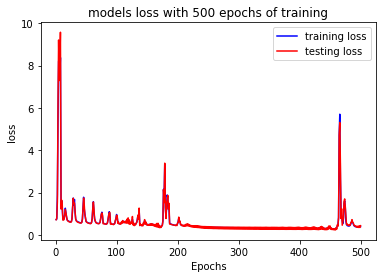

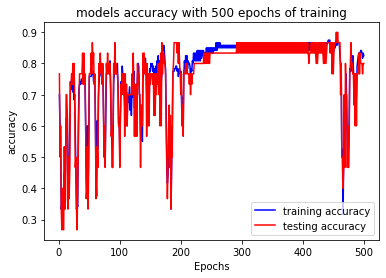

In [131]:
myMlp.train(data, labels, 500, 0.1)

In [12]:
def perceptron(X, Y, epochs, learning_rate):
    
    x_in = X.shape[1:]
    input_x = Input(x_in)
    x = Dense(4, activation= 'tanh')(input_x)
    x = Dense(4, activation='tanh')(x)
    x = Dense(4, activation='tanh')(x)
    x = Dense(4, activation='tanh')(x)
    x = Dense(3, activation='softmax')(x)
    model = tf.keras.Model(input_x, x)
    opt = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)
    #opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X, Y, epochs = epochs)

perceptron(data, labels, 100, 0.01)

Train on 150 samples
Epoch 1/100
150/150 [==============================] - 2s 12ms/sample - loss: 1.1002 - accuracy: 0.3333
Epoch 2/100
150/150 [==============================] - 0s 200us/sample - loss: 1.0798 - accuracy: 0.3333
Epoch 3/100
150/150 [==============================] - 0s 206us/sample - loss: 1.0593 - accuracy: 0.3467
Epoch 4/100
150/150 [==============================] - 0s 196us/sample - loss: 1.0395 - accuracy: 0.4667
Epoch 5/100
150/150 [==============================] - 0s 184us/sample - loss: 1.0194 - accuracy: 0.5867
Epoch 6/100
150/150 [==============================] - 0s 176us/sample - loss: 0.9992 - accuracy: 0.6667
Epoch 7/100
150/150 [==============================] - 0s 193us/sample - loss: 0.9793 - accuracy: 0.6667
Epoch 8/100
150/150 [==============================] - 0s 181us/sample - loss: 0.9607 - accuracy: 0.6667
Epoch 9/100
150/150 [==============================] - 0s 194us/sample - loss: 0.9414 - accuracy: 0.6667
Epoch 10/100
150/150 [=============

150/150 [==============================] - 0s 167us/sample - loss: 0.5330 - accuracy: 0.6667
Epoch 79/100
150/150 [==============================] - 0s 154us/sample - loss: 0.5318 - accuracy: 0.6667
Epoch 80/100
150/150 [==============================] - 0s 156us/sample - loss: 0.5307 - accuracy: 0.6667
Epoch 81/100
150/150 [==============================] - 0s 152us/sample - loss: 0.5298 - accuracy: 0.6667
Epoch 82/100
150/150 [==============================] - 0s 176us/sample - loss: 0.5286 - accuracy: 0.6667
Epoch 83/100
150/150 [==============================] - 0s 163us/sample - loss: 0.5274 - accuracy: 0.6667
Epoch 84/100
150/150 [==============================] - 0s 168us/sample - loss: 0.5265 - accuracy: 0.6667
Epoch 85/100
150/150 [==============================] - 0s 213us/sample - loss: 0.5254 - accuracy: 0.6667
Epoch 86/100
150/150 [==============================] - 0s 195us/sample - loss: 0.5244 - accuracy: 0.6667
Epoch 87/100
150/150 [==============================] - 0s 

(array([  0,   4,   5,   6,   7,   8,   9,  13,  14,  16,  17,  20,  21,
        22,  23,  24,  27,  28,  30,  32,  33,  34,  36,  37,  41,  42,
        43,  45,  47,  50,  51,  53,  57,  58,  60,  62,  63,  64,  66,
        71,  72,  76,  78,  86,  88,  89,  92,  93,  94,  96,  97,  99,
       100, 101, 102, 107, 109, 111, 112, 113, 115, 117, 122, 123, 126,
       127, 133, 136, 137, 138, 139, 140, 141, 148, 149]), array([  1,   2,   3,  10,  11,  12,  15,  18,  19,  25,  26,  29,  31,
        35,  38,  39,  40,  44,  46,  48,  49,  52,  54,  55,  56,  59,
        61,  65,  67,  68,  69,  70,  73,  74,  75,  77,  79,  80,  81,
        82,  83,  84,  85,  87,  90,  91,  95,  98, 103, 104, 105, 106,
       108, 110, 114, 116, 118, 119, 120, 121, 124, 125, 128, 129, 130,
       131, 132, 134, 135, 142, 143, 144, 145, 146, 147]))
